In [1]:
!pip install wordcloud
!pip install gensim

In [2]:
import os.path

DATASET = 'clicr'

# MODEL = 'bert-base-cased'
# MODEL = 'dmis-lab/biobert-base-cased-v1.1'
# MODEL = 'fagner/envoy'
# MODEL = 'sts-biobert'
MODEL = 'sts-bert'
# MODEL = 'iln-biobert'
# MODEL = 'iln-envoy'


TXT_INPUT_FILE = '../datasets/' + DATASET + '/sequences.txt'
TSV_INPUT_PATH = '../from_embeddings_to_tsv/output_from_2/' + DATASET + '/' + MODEL + '/'

OUTPUT_PATH = 'output/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += 'MNT/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += DATASET + '/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += MODEL + '/'
if not os.path.exists(OUTPUT_PATH): os.makedirs(OUTPUT_PATH, exist_ok=True)

with open(TXT_INPUT_FILE) as f:
    data_samples = f.readlines()

# Etapa 1: Modelagem de Sentenças

In [3]:
import pandas as pd

embeddings_dataframe = pd.read_csv(TSV_INPUT_PATH + 'word_embeddings.tsv', sep='\t',header=None)
sentences_dataframe = pd.read_csv(TSV_INPUT_PATH + 'labels.tsv', sep='\t',header=None)

print('Sentenças: ')
print(sentences_dataframe, '\n\n')
print('Dimensão dos Embeddings: ', embeddings_dataframe.shape)


embeddings_numpy = embeddings_dataframe.to_numpy()
sentences_numpy = sentences_dataframe.to_numpy()
# print(sentences_numpy)
X_embeddings = embeddings_numpy[:, :-1]

sentences = []
# print(len(X_embeddings))
for x in range(len(X_embeddings)):
    sentences.append(x)

Sentenças: 
                                                       0
0      Summary This report describes a term newborn w...
1      Summary A 40 - year - old man presented with a...
2      A 40 - year - old man presented with shortness...
3      Summary Pregnancy with liver cirrhosis is a ra...
4      Description On examination , his built was nor...
...                                                  ...
10633  Description Urachal cancers are rare , account...
10634  Summary A 4.3 Mb duplication of chromosome 21 ...
10635  Summary Primary thymic extranodal marginal zon...
10636  Summary A 42 - year - old woman presented to o...
10637  Summary A woman in her 40s originally from Zim...

[10638 rows x 1 columns] 


Dimensão dos Embeddings:  (10638, 769)


### Visualização em 2d dos Embeddings de Sentença

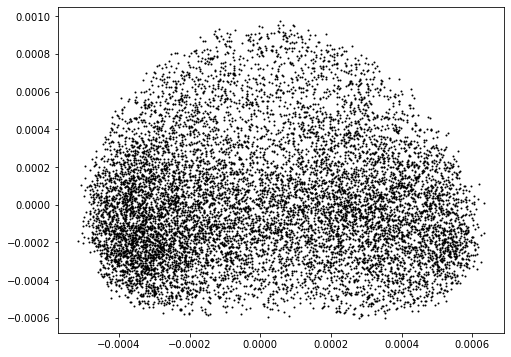

In [4]:
from matplotlib import pyplot as plt 
from sklearn import manifold

X_2d = manifold.SpectralEmbedding(n_components=2).fit_transform(X_embeddings)

x = X_2d[:,0]
y = X_2d[:,1]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='black', s=1)

# for i, sentence in enumerate(sentences):
#     plt.annotate(sentence, (x[i], y[i]), fontsize=15)

plt.savefig(OUTPUT_PATH + 'sentence-embeddings')

# Etapa 2: Agrupamento de Sentenças

In [5]:
distance_threshold = 140

In [6]:
from sklearn.cluster import AgglomerativeClustering

clusterings = []
n_clusters = []
colors = []

clustering = AgglomerativeClustering(linkage='ward', distance_threshold=distance_threshold, n_clusters=None)
clustering = clustering.fit(X_embeddings)
selected_colors = [plt.cm.nipy_spectral(label / 10.) for label in clustering.labels_]
n_clusters = clustering.n_clusters_

### 2.1 Visualizar agrupamento 

Limiar de distância:  140
Tópicos resultantes 2


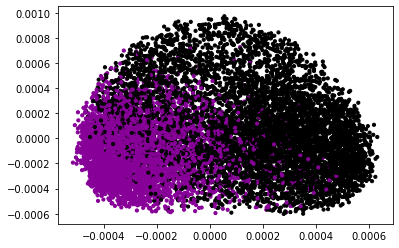

In [7]:
plt.figure(figsize=(6, 4))

plt.scatter(x, y, color=selected_colors, s=10, cmap='hsv_r')

print('Limiar de distância: ', distance_threshold)
print('Tópicos resultantes',  n_clusters)

plt.savefig(OUTPUT_PATH + 'clusters')

### 2.2 Visualizar dendrograma

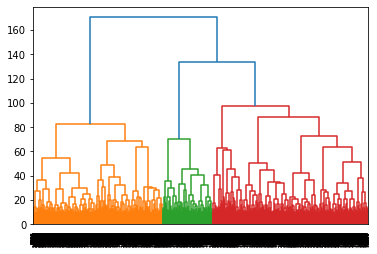

In [8]:
from scipy.cluster.hierarchy import dendrogram
import numpy as np


counts = np.zeros(clustering.children_.shape[0])
n_samples = len(clustering.labels_)
merge = clustering.children_
current_count = 0

for child_idx in merge:
    if len(child_idx) < n_samples:
        current_count += 1  # leaf node
    else:
        current_count += counts[child_idx - n_samples]
counts[0] = current_count

linkage_matrix = np.column_stack([clustering.children_, clustering.distances_, counts]).astype(float)

plt.figure()
dendrogram(linkage_matrix)

plt.savefig(OUTPUT_PATH + 'dendrograma')
plt.show()

# Etapa 3: Extração de Tópicos

In [13]:
MAX_DF = 0.95

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS 
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from nltk.tokenize import RegexpTokenizer

topics = []
topics_txt = [''] * n_clusters

for i in range(len(sentences)):
    cluster_index = clustering.labels_[i]
    sentence = sentences_numpy[i] + ' | '
    topics_txt[cluster_index] += sentence

for document in topics_txt:
    topics.append(str(document).split('[')[1].replace('[', '').replace(']\n', '').replace('\'', ''))

# tf_idf_vectorizer = TfidfVectorizer(max_df=MAX_DF)


In [ ]:
tf_idf_vectorizer = TfidfVectorizer(stop_words='english')
# tf_idf_vectorizer = TfidfVectorizer(max_df=MAX_DF)

document_term_matrix = tf_idf_vectorizer.fit_transform(topics)
terms = tf_idf_vectorizer.get_feature_names_out()
terms_by_topic = tf_idf_vectorizer.inverse_transform(document_term_matrix)
tfidf_matrix = document_term_matrix.toarray()

top_terms_by_topic = []
top_tfidfs_by_cluster = []

## Itera sobre cada documento (tópico/cluster) 
for topic in range(len(topics)):
    sorted_tfidf = np.argsort(tfidf_matrix[topic])

    # top_tfidf_indexes = sorted_tfidf[:]
    top_tfidf_indexes = sorted_tfidf[-20:]
    
    top_terms,top_tfidfs = [],[]
    for h in sorted_tfidf:
        top_terms.append(terms[h])
        top_tfidfs.append(tfidf_matrix[topic][h])
       
    top_terms_by_topic.append(top_terms)
    top_tfidfs_by_cluster.append(top_tfidfs)
        
        
        
    #################################################################
    #################################################################
    ## Plotar WordCloud
    #################################################################
    #################################################################
    dense = document_term_matrix[topic].todense()
    lst1 = dense.tolist()
    tfidf_data_frame = pd.DataFrame(lst1, columns=terms)

    wordcloud = WordCloud(background_color=None, max_words=50).generate_from_frequencies(tfidf_data_frame.T.sum(axis=1))
    plt.figure(figsize=(6, 4))
    plt.axis("off")
    plt.set_title(f"Tópico {topic+1}", fontdict={"fontsize": 25})

    plt.imshow(wordcloud)
    plt.savefig(OUTPUT_PATH + "wc"+ str(topic+1) + '.jpg')
    # plt.show()
    
        plt.set_title(f"Tópico {topic+1}", fontdict={"fontsize": 25})

    
    
    #################################################################
    #################################################################
    ## Plotar Gráfico de Barras
    #################################################################
    #################################################################
    # plt.figure()
    
    # hidden_topterms = [len(top_terms)]
    # hidden_topterms = []
    # hidden_topterms = np.arange(len(top_terms), dtype="str")
    # print(type(hidden_topterms[0]))
    # for j in range(len(top_terms)):
    #     if j%1000 != 0:
    #         # hidden_topterms[j] = "" 
    #         hidden_topterms[j] = ""
    #     else: hidden_topterms[j] = top_terms[j]

        # else: print('ok')

    # print(len(hidden_topterms))
    # print(len(top_terms))
    
    # print(hidden_topterms[:1001])
    # print(top_terms[:1001])

    fig, ax = plt.subplots(figsize=(6, 10))
    # ax.tick_params(axis="both", which='major', labelsize=1)
    # ax.barh(" ", 0, color='gray', align="edge")
    for j in range(len(top_terms)):
        if (top_tfidfs[j]) != 0:
            ax.barh(top_terms[j], top_tfidfs[j], color='gray', edgecolor='gray')
    # The colors of the bar edges.
        # if (top_tfidfs[j]) != 0:
        #     if j%100 != 0:
        #         print('pltei')
        #         ax.barh(" ", top_tfidfs[j], color='gray', align="edge")
        #     else: 
        #         print('pltando aqui')
        #         ax.barh(top_terms[j], top_tfidfs[j], color='gray', align="edge")
        
        # if j%100 != 0:
        #     # print('pltei')
        #     ax.barh(".", 1, color='gray', align="edge")
        #     # print('plotou mesmo')
        # else: 
        #     # print('pltando aqui')
        #     ax.barh(top_terms[j], top_tfidfs[j], color='gray', align="edge")
        
    # ax.set_yscale("log")
    # ax.set_xscale("log")
    ax.invert_yaxis()
    ax.set_title(f"Tópico {topic+1}", fontdict={"fontsize": 25})

    for j in "top right left".split():
        ax.spines[j].set_visible(True)
        
    # print(len(top_terms_by_topic))
    
    # plt.show()
    plt.savefig(OUTPUT_PATH + 'distribution'+ str(topic+1) +'.jpg')

dictionary = Dictionary(terms_by_topic)
corpus = [dictionary.doc2bow(text) for text in terms_by_topic]
texts = [[dictionary[word_id] for word_id, freq in doc] for doc in corpus]
cm = CoherenceModel(topics=top_terms_by_topic, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v',topn=20)

print('Coerência: ',cm.get_coherence())
print('Coerência por Tópico: ',cm.get_coherence_per_topic())    
print('----------------------\n\n')        
plt.show()

with open(OUTPUT_PATH + '/notes.txt', "w") as file:
    print('Limiar de distância: '+str(distance_threshold), file=file)   
    print('Qtdd de Tópicos: '+str(n_clusters), file=file)   
    print('Limiar TF-IDF: '+str(MAX_DF), file=file)  
    print('Coerência total: '+str(cm.get_coherence()), file=file)  
    print('Coerência por Tópcios: '+str(cm.get_coherence_per_topic()), file=file)  
    print('----------------------------------------------------------------------------', file=file)  

In [12]:
print(OUTPUT_PATH)
with open(OUTPUT_PATH + '/notes.txt', "w") as file:
    print('Limiar de distância: '+str(distance_threshold), file=file)   
    print('Qtdd de Tópicos: '+str(n_clusters), file=file)   
    print('Limiar TF-IDF: '+str(MAX_DF), file=file)  
    print('Coerência total: '+str(cm.get_coherence()), file=file)  
    print('Coerência por Tópcios: '+str(cm.get_coherence_per_topic()), file=file)  
    print('----------------------------------------------------------------------------', file=file)  

output/MNT/clicr/sts-bert/


In [37]:
# print(len(terms_by_topic[1]))
# print(len(dictionary))
print(len(top_terms))

19223


In [43]:
dictionary = Dictionary(terms_by_topic)
corpus = [dictionary.doc2bow(text) for text in terms_by_topic]
texts = [[dictionary[word_id] for word_id, freq in doc] for doc in corpus]
cm = CoherenceModel(topics=top_terms_by_topic, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v', topn=2)

BERT
Coerência:  0.6477211095881088
Coerência por Tópico:  [0.36116905907680613, 0.9342731600994115]
Coerência:  0.42686832395976854
Coerência por Tópico:  [0.47063782189850095, 0.3889105675879395, 0.4167050260817846, 0.36387730119270123, 0.4342760902925517, 0.42914052475385495, 0.4845309359110467]

iln-biobert


In [44]:
cm.get_coherence()

0.3042064322467919

BERT
df = 0.5
Limiares:  [60, 45, 40, 30, 20, 10, 1]
Clusters:  [2, 4, 5, 9, 18, 71, 10635]
Coerência:  0.880365483055876
Coerência por Tópico:  [0.8749964931287185, 0.8857344729830335]
Coerência:  0.8528495610238859
Coerência por Tópico:  [0.8833804320034777, 0.9040703980014335, 0.7767621649003849, 0.84718524919024]
Coerência:  0.8227156012971901
Coerência por Tópico:  [0.9029409702806567, 0.7539081396509932, 0.7446574543125121, 0.8205262851406805, 0.8915451571011084]
Coerência:  0.8047054054539997
Coerência por Tópico:  [0.6702796676965264, 0.8582521902908966, 0.8106504898260777, 0.9263032646195036, 0.8972842548498684, 0.8858151729658422, 0.6357054520814951, 0.8426333886638955, 0.7154247680918909]
Coerência:  0.8231662301717604
Coerência por Tópico:  [0.899768911500819, 0.7724448566374871, 0.6279169987994495, 0.8839148405051644, 0.8696903003718157, 0.9114630477669876, 0.7677659214079711, 0.5708077629178022, 0.8575694781332664, 0.9164178472836106, 0.8819157080793866, 0.8392842180433077, 0.896082078569098, 0.8442143230025391, 0.709437895358853, 0.8768025530997027, 0.8874310890537457, 0.8040643125606821]
Coerência:  0.7831381829160984
Coerência por Tópico:  [0.717537285846677, 0.504506736088343, 0.8024774929502877, 0.574663274659745, 0.843232576903417, 0.8865270182658349, 0.7337383011272088, 0.7770606456265995, 0.8676303472479138, 0.8756579949413552, 0.8898528459233548, 0.8896970673335042, 0.8346130046536837, 0.7515613982328682, 0.8815650219264727, 0.7701596361282099, 0.7815940404152356, 0.8714685533675061, 0.8570244153424613, 0.8602753053297567, 0.8713361681367726, 0.8491533683864587, 0.8401487340109445, 0.8671183200276958, 0.44004880168974964, 0.7952284044811629, 0.8513423152896672, 0.8622847616755845, 0.8575907004218315, 0.8497145722429227, 0.8053755576876891, 0.7018524766328745, 0.6732117834238714, 0.8143566974690838, 0.7076146053440976, 0.8857630714462061, 0.8727683643177809, 0.8479270184879857, 0.8787126165893753, 0.8581597791779323, 0.7816329214316902, 0.8896190077344494, 0.7589749296369416, 0.5832616912168421, 0.8520875648801568, 0.8718233655619798, 0.8421785816626415, 0.7637997119212883, 0.8559316733674882, 0.8538258423117594, 0.874101844621717, 0.85468106308921, 0.7264950145629565, 0.8480955698491853, 0.26501743818133083, 0.5514986856146448, 0.8502674699802167, 0.8504078332552102, 0.42423270947225045, 0.849259605133568, 0.7949989780447091, 0.8372583947145654, 0.7520833387940634, 0.5985760851570909, 0.8637906692802539, 0.8325071978854779, 0.8414476586548347, 0.7391534444547321, 0.7939352795264015, 0.5082501219941964, 0.7930662158010127]
Quantidade de clusters resultantes:  10635 QUEERBROUR!!!!!


df=0.5
BioBERTCoerência:  0.8833622688645804
Coerência por Tópico:  [0.882213967376493, 0.8845105703526677]
Coerência:  0.8833622688645804
Coerência por Tópico:  [0.882213967376493, 0.8845105703526677]
Coerência:  0.8361472695054407
Coerência por Tópico:  [0.8640645784937714, 0.8468735334174248, 0.7975036966051262]
Coerência:  0.8677403692823907
Coerência por Tópico:  [0.851869432712566, 0.8694376455182642, 0.8429399985860668, 0.9067144003126663]
Coerência:  0.8261732170568579
Coerência por Tópico:  [0.6701974757580015, 0.8323951283915488, 0.8187786940392886, 0.8082405294064349, 0.7179830038638271, 0.875716953068385, 0.9176026038803698, 0.8926882513093822, 0.9019563137944833]
Coerência:  0.813749221682567
Coerência por Tópico:  [0.5965944757327533, 0.8822389181648641, 0.8958386903699284, 0.8874670301244018, 0.7793095095528103, 0.7583175929021492, 0.6680461830821504, 0.8833349204419971, 0.8617153382426003, 0.7512327554406787, 0.8879704899515657, 0.7304185309294908, 0.885183195781994, 0.8428557914223163, 0.8957149030988034]
Quantidade de clusters resultantes:  55
Coerência:  0.7890953727654199
Coerência por Tópico:  [0.7890811082691718, 0.8342900539018746, 0.665953132335072, 0.7508943460149401, 0.8204716329517875, 0.8000307730614767, 0.8234086517405715, 0.8397597577710129, 0.8738321956193111, 0.6083583495520132, 0.6723885304071194, 0.843031519054713, 0.8263561986111385, 0.8702325748847407, 0.896378557719384, 0.8743738621561539, 0.8015239998783339, 0.8244156556844657, 0.8154563829650757, 0.8909637122428308, 0.7589124107538175, 0.8736225846949595, 0.8456279050938669, 0.8472223486952943, 0.818197301847879, 0.8651575735457111, 0.8439581210732174, 0.8477638629253269, 0.6767204911175049, 0.7544753005257496, 0.8079787507101142, 0.7215152560294377, 0.8889463200820754, 0.7521812383460081, 0.8582873885467088, 0.8698589929927052, 0.8528810039713075, 0.8582992902852657, 0.8825299295563276, 0.8616215350372295, 0.8486031251898791, 0.7578327587302947, 0.8716610512170646, 0.7352617763363007, 0.7970496800609762, 0.879409536881257, 0.71880322369069, 0.8403866761739539, 0.8448968370573788, 0.5085916825872832, 0.6935168197467785, 0.6685155202990031, 0.8431013804763556, 0.45616819871469716, 0.3294886342844924]

Quantidade de clusters resultantes:  65
Coerência:  0.7859720271786592
Coerência por Tópico:  [0.36595995796173036, 0.7875640406228104, 0.49056194829749394, 0.7464493970990723, 0.5326824842652166, 0.7553814828625772, 0.8730302763564919, 0.7953432039298307, 0.8454446629680349, 0.693957601920775, 0.8537840498003791, 0.8540508318030411, 0.8543903588012115, 0.7040357612579349, 0.787609494361272, 0.8638198685947356, 0.8708403137808642, 0.8613234771951837, 0.8565973961910432, 0.8401912520236139, 0.8543179650141299, 0.717999367628825, 0.8334552242435997, 0.8564394228884942, 0.8134095448371018, 0.8765222486978604, 0.8355544038561703, 0.8478795561155388, 0.886236413697568, 0.7891677197532256, 0.7213521586854579, 0.7691984651955102, 0.8802154066735309, 0.7659640858694305, 0.8713414859989264, 0.7769437158213165, 0.8493799030340419, 0.8580726252491724, 0.8772248805228893, 0.8462939739949691, 0.8562143542824856, 0.7772887369649993, 0.8288134874990065, 0.8710128554447735, 0.8329108934379117, 0.8719190971688833, 0.7222634457408295, 0.8447653101866477, 0.8499383196794291, 0.5341830438142471, 0.687908378258402, 0.6708797685526008, 0.8477544758504739, 0.4761521971792449, 0.3591666891512919, 0.855110590654444, 0.8907106689142053, 0.7047072105837683, 0.8513723135826251, 0.7940034092766042, 0.8238919497184828, 0.821644817773078, 0.8594974175060496, 0.8668213782799274, 0.829264529241372]